In [1]:
%%capture
pip install fa2_modified

In [2]:
%%capture
pip install powerlaw

In [3]:
import ast
from fa2_modified import ForceAtlas2
from itertools import combinations
import json
import math
import matplotlib as mpl
from matplotlib import colormaps
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import powerlaw
import random
import re
from statistics import mean, median, mode
from tqdm import tqdm
import urllib.request

# The Data

The data used in this graph is comprised of 3 _.csv_-files:

- _TMDB\_scraped\_features.csv_ (7.1 Mb)
- _TMDB\_scraped\_actors.csv_ (10.1 Mb)
- _WIKI\_scraped\_pages.csv_ (119 Mb)

### Downloading the data of the network

In [4]:
# Loacte the data files in folder
TMDB_SCRAPED_FEATURES_PATH = os.path.join(os.path.abspath(""), "data", "TMDB_scraped_features.csv")
TMDB_SCRAPED_ACTORS_PATH = os.path.join(os.path.abspath(""), "data", "TMDB_scraped_actors.csv")
WIKI_SCRAPED_PAGES_PATH = os.path.join(os.path.abspath(""), "data", "WIKI_scraped_pages.csv")

# Print paths
print(TMDB_SCRAPED_FEATURES_PATH)
print(TMDB_SCRAPED_ACTORS_PATH)
print(WIKI_SCRAPED_PAGES_PATH)

/home/aleksandar-lukic/school/02805_Final_project/code/TMDB_scraped_features.csv
/home/aleksandar-lukic/school/02805_Final_project/code/TMDB_scraped_actors.csv
/home/aleksandar-lukic/school/02805_Final_project/code/WIKI_scraped_pages.csv


In [5]:
# Create DataFrames from csv-files
features_df = pd.read_csv(TMDB_SCRAPED_FEATURES_PATH)
actors_df = pd.read_csv(TMDB_SCRAPED_ACTORS_PATH)
wiki_df = pd.read_csv(WIKI_SCRAPED_PAGES_PATH)

Here are some examples to show the content of the DataFrames:

### Features DataFrame

In [6]:
features_df.head(1)

,feature_id,title,original_language,overview,cast,feature_popularity,vote_count,vote_average,release_date,genre_ids,poster_path,backdrop_path,adult,page,wikidata_id
0,278,The Shawshank Redemption,en,Imprisoned in the 1940s for the double murder ...,"[504, 192, 4029, 6573, 6574, 6575, 6577, 6576,...",157.766,27254,8.7,1994-09-23,"[18, 80]",/9cqNxx0GxF0bflZmeSMuL5tnGzr.jpg,/zfbjgQE1uSd9wiPTX4VzsLi0rGG.jpg,False,1,Q172241


Since the features will be used to create edges/links in a network later on, it is crucial that every feature has a cast, staring at least two actors. 

Thus, the dataframe is cleaned, just in case.

In [7]:
features_df_old = features_df

In [8]:
features_df = features_df.dropna(subset=["cast"])
features_df = features_df[features_df["cast"].apply(len) >= 2]

print(f"Before cleaning: {features_df_old.shape}")
print(f"After cleaning : {features_df.shape}")

Before cleaning: (9695, 15)
After cleaning : (9695, 15)


### Actors example

In [9]:
print(f"The actors_df contains:\n{actors_df.shape[0]} rows\n{actors_df.shape[1]} columns")

The actors_df contains:
188145 rows
7 columns


In [10]:
actors_df.head(1)

,actor_id,original_name,actor_popularity,gender,adult,profile_image_path,featured_in
0,1,George Lucas,20.273,2,False,/WCSZzWdtPmdRxH9LUCVi2JPCSJ.jpg,"[1895, 87, 607, 879, 306]"


### Wikipedia example

In [11]:
print(f"The wiki_df contains:\n{wiki_df.shape[0]} rows\n{wiki_df.shape[1]} columns")

The wiki_df contains:
9438 rows
6 columns


In [12]:
wiki_df.head(1)

,feature_id,title,url,page_content,content_size,wikidata_id
0,2,Ariel,https://en.wikipedia.org/wiki/Ariel_(film),Ariel is a 1988 Finnish drama film directed an...,3346,Q658627


# The Actor Network

The Actor network is generated from: 

In [13]:
# Initialize a NetworkX MultiGraph to store the Actor-network
G = nx.MultiGraph()

## Adding the Actors as Nodes

In [14]:
# Traverse the actors dataframe and 
# add each row as a node with attributes
progress_bar = tqdm(actors_df.iterrows(), total=len(actors_df), desc="Generating nodes in network")

for idx, row in progress_bar:
    node_id = int(row["actor_id"])
    #attributes = row.drop('actor_id').to_dict()
    actor_attributes = {
        "original_name": row["original_name"],
        "featured_in": len(row["featured_in"])
    }
    G.add_node(node_id, **actor_attributes)

Generating nodes in network: 100%|████| 188145/188145 [00:02<00:00, 66882.23it/s]


In [15]:
print("Nodes:", len(G.nodes()))

Nodes: 188145


## Adding the Features as Edges

In [16]:
# Traverse the features dataframe and 
# add for each row, edges between any 
# two actors in the cast list.

progress_bar = tqdm(features_df.iterrows(), total=len(features_df), desc="Generating edges in network")

for idx, row in progress_bar:
    
    # Load movie's cast list
    actor_ids = row["cast"]
    
    # Convert the str to a list of int
    actor_ids = ast.literal_eval(actor_ids)
    
    # Get movie data to store in edge
    feature_attributes = {"feature_id": row["feature_id"]}
    
    # Create all pairs of actor_ids
    for pair in [(id1, id2) for (id1, id2) in combinations(actor_ids, 2)]:
        G.add_edge(pair[0], pair[1], **feature_attributes)

Generating edges in network: 100%|██████████| 9695/9695 [00:20<00:00, 471.05it/s]


In [17]:
print("Edges:", len(G.edges()))

Edges: 9867443


## Cleaning up a bit

The raw network created from cross-referencing actors starring in the same movie for every movie in the dataset, would contain approx. 190.000 nodes and a whopping 10 mio edges!

Due to computational constraints, using this network would not be a feasible endeavour. 

Therefore, it was neccessary to crop the dataset used in this project.

## Removing actors with fewer roles

The dataset contains a lot of actors, some of them have starred in many movies, while others only in a few.

Since the size of a movies cast can artificially inflate the degrees in the network, the actors with fewer roles are removed.

In [18]:
MIN_FEATURED_IN = 50

In [19]:
nodes_with_few_features = [
    node for node, data in G.nodes(data=True) if data.get("featured_in") is None or data.get("featured_in") <= MIN_FEATURED_IN
]

print(f"There are {len(nodes_with_few_features)} actors, who have starred in less than {MIN_FEATURED_IN} movies!")

There are 181764 actors, who have starred in less than 50 movies!


In [20]:
G.remove_nodes_from(list(nodes_with_few_features))

print("Nodes:", len(G.nodes()))
print("Edges:", len(G.edges()))

Nodes: 6381
Edges: 625120


### Removing self-loops

In [21]:
# Create placeholder for old values
G_copy = G.copy()

# Remove self-loops in order to make the final plot prettier.
G.remove_edges_from(list(nx.selfloop_edges(G)))

# No. of selfloops removed
diff = len(G_copy.edges()) - len(G.edges())

print(f"Removed {diff} self-loops!")

Removed 79 self-loops!


In [22]:
print("Edges:", len(G.edges()))

Edges: 625041


### Removing nodes with too low degree

As there are currently 190.000 nodes, it is advised to remove nodes with limiting added value to the network. These might be nodes, i.e. actors, staring in very few movies, or have not starred along many other actors. 

In [23]:
# sort nodes after degree
G_sorted_degree = sorted(G.degree, key=lambda x: x[1], reverse=True)

# Extract degree from nodes and store separately
G_degree_values = [x[1] for x in G_sorted_degree]

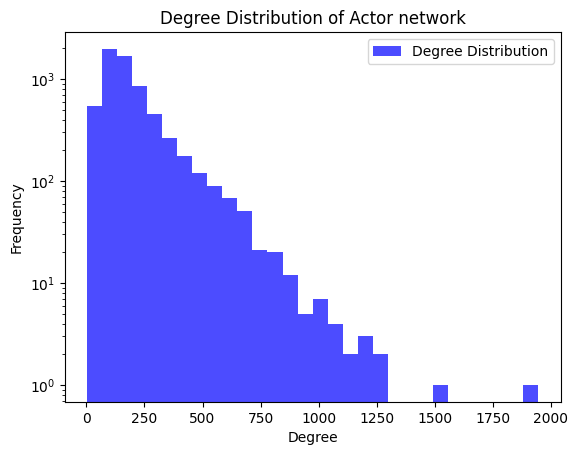

In [24]:
# Histogram of In-degree Distribution
plt.hist(
    G_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="Degree Distribution", 
    color="blue"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("Degree Distribution of Actor network")

DEGREE_DISTRIBUTION_PATH_PDF = os.path.join(os.path.abspath(""), "plots", "degree_distribution.pdf")
DEGREE_DISTRIBUTION_PATH_PNG = os.path.join(os.path.abspath(""), "plots", "degree_distribution.png")
plt.savefig(DEGREE_DISTRIBUTION_PATH_PDF, format = "pdf", bbox_inches="tight")
plt.savefig(DEGREE_DISTRIBUTION_PATH_PNG, format = "png", bbox_inches="tight")

plt.show()

In [25]:
# MIN_DEGREE = 100

In [26]:
# # Identify nodes with a degree less than minimum
# nodes_to_remove = [node for node, degree in G.degree() if degree < MIN_DEGREE]
# len(nodes_to_remove)

In [27]:
# # Remove those nodes
# G.remove_nodes_from(nodes_to_remove)

In [28]:
# print("G after degree removal:")
# print("Nodes:", len(G.nodes()))
# print("Edges:", len(G.edges()))

### Extract the largest connected component

As a result of the data collection process, the network is inherently fully connected, making the graph equivalent to its largest connected component.

In [29]:
# Extract the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create new graph from largest connected component
S = G.subgraph(largest_cc).copy()

In [30]:
print("G->S after extracting LCC:")
print("Nodes:", len(S.nodes()))
print("Edges:", len(S.edges()))

G->S after extracting LCC:
Nodes: 6381
Edges: 625041


# The (Compressed) Actor Network

Since the complete Actor network contains movies with enourmous cast sizes, it would be useful to limit the number of actors added per movie. To handle this, there is a cap on the cast size, where all actors mentioned in the "cast" attribute of a feature, are skipped. 

First, a copy is created with only the nodes and their attributes parsed.

Secondly, the edges are added once more. However, this time only the 10 first actors mentioned in the features "cast" list, are included.

In [31]:
G_comp = nx.MultiGraph() 

# Copy only the nodes (and their attributes)
G_comp.add_nodes_from(G.nodes(data=True))

# Traverse the features dataframe and 
# add for each row, edges between any 
# two actors in the cast list.

progress_bar = tqdm(features_df.iterrows(), total=len(features_df), desc="Generating edges in network")

for idx, row in progress_bar:
    
    # Load movie's cast list
    actor_ids = row["cast"]
    
    # Convert the str to a list of int
    actor_ids = ast.literal_eval(actor_ids)
    
    # Get movie data to store in edge
    feature_attributes = {"feature_id": row["feature_id"]}
    
    # Create all pairs of actor_ids
    for pair in [(id1, id2) for (id1, id2) in combinations(actor_ids, 2)]:
        G_comp.add_edge(pair[0], pair[1], **feature_attributes)

Generating edges in network: 100%|██████████| 9695/9695 [00:32<00:00, 297.90it/s]


In [32]:
print("Nodes:", len(G_comp.nodes()))
print("Edges:", len(G_comp.edges()))

Nodes: 188007
Edges: 9867443


In [33]:
MAX_CAST_SIZE = 10

In [34]:
G_comp = nx.MultiGraph() 

# Copy only the nodes (and their attributes)
G_comp.add_nodes_from(G.nodes(data=True))

# Traverse the features dataframe and 
# add for each row, edges between any 
# two actors in the cast list.

progress_bar = tqdm(features_df.iterrows(), total=len(features_df), desc="Generating edges in network")

for idx, row in progress_bar:
    
    # Load movie's cast list
    actor_ids = row["cast"]
    
    # Convert the str to a list of int
    actor_ids = ast.literal_eval(actor_ids)
        
    if len(actor_ids) > MAX_CAST_SIZE:
        actor_ids = actor_ids[:MAX_CAST_SIZE]
    
    # Get movie data to store in edge
    feature_attributes = {"feature_id": row["feature_id"]}
    
    # Create all pairs of actor_ids
    for pair in [(id1, id2) for (id1, id2) in combinations(actor_ids, 2)]:
        G_comp.add_edge(pair[0], pair[1], **feature_attributes)

Generating edges in network: 100%|█████████| 9695/9695 [00:01<00:00, 8427.33it/s]


In [35]:
print("Nodes:", len(G_comp.nodes()))
print("Edges:", len(G_comp.edges()))

Nodes: 40602
Edges: 429290


In [36]:
MIN_FEATURED_IN = 50
nodes_with_few_features = [
    node for node, data in G_comp.nodes(data=True) if data.get("featured_in") is None or data.get("featured_in") <= MIN_FEATURED_IN
]

print(f"There are {len(nodes_with_few_features)} actors, who have starred in less than {MIN_FEATURED_IN} movies!")

There are 34221 actors, who have starred in less than 50 movies!


In [37]:
G_comp.remove_nodes_from(list(nodes_with_few_features))

print("Nodes:", len(G_comp.nodes()))
print("Edges:", len(G_comp.edges()))

Nodes: 6381
Edges: 134797


### Degree distribution of compressed graph

In [38]:
# Create placeholder for old values
G_comp_copy = G_comp.copy()

# Remove self-loops in order to make the final plot prettier.
G_comp.remove_edges_from(list(nx.selfloop_edges(G_comp)))

# No. of selfloops removed
diff = len(G_comp_copy.edges()) - len(G_comp.edges())

print(f"Removed {diff} self-loops!")

Removed 1 self-loops!


In [39]:
# sort nodes after degree
G_comp_sorted_degree = sorted(G_comp.degree, key=lambda x: x[1], reverse=True)

# Extract degree from nodes and store separately
G_comp_degree_values = [x[1] for x in G_comp_sorted_degree]

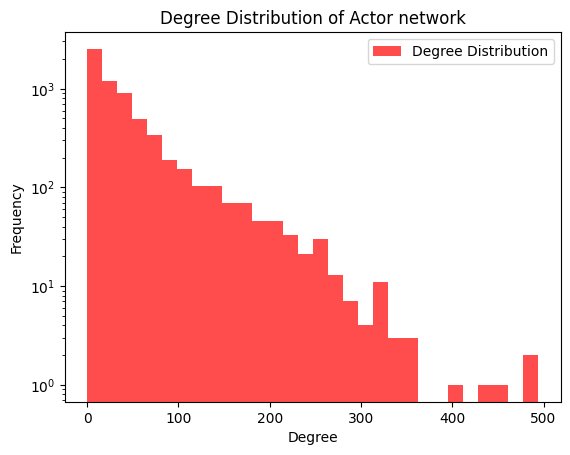

In [40]:
# Histogram of In-degree Distribution
plt.hist(
    G_comp_degree_values, 
    bins=30, 
    alpha=0.7, 
    label="Degree Distribution", 
    color="red"
)

# Settings of axis/plot
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("Degree Distribution of Actor network")
plt.show()

# Actors with highest degree

The actors with the highest degrees are the actors, who have starred along side many other actors. This could indicate, that the actors have either starred in a lot of movies, or have starred in movies with very large casts.

In [41]:
i = 1
for node, degree in G_comp_sorted_degree[:10]:
    idx = f"{i}. "
    name = f"{G_comp.nodes[node]["original_name"]}"
    degree = f"{degree}"
    
    line = [idx, name, degree]
    print("{: >4} {: <17} degree : {: <5}".format(*line))
    i = i+1

 1.  Robert De Niro    degree : 494  
 2.  Samuel L. Jackson degree : 489  
 3.  Bruce Willis      degree : 459  
 4.  Nicolas Cage      degree : 442  
 5.  Morgan Freeman    degree : 402  
 6.  Johnny Depp       degree : 355  
 7.  Woody Harrelson   degree : 351  
 8.  Tom Hanks         degree : 350  
 9.  Matt Damon        degree : 335  
10.  Willem Dafoe      degree : 333  


# Actors who starred in most movies

The actors who starred in the most are the actors, who have been active for a longer time and thereby may have starred along side many other actors.

In [42]:
# Extract nodes and the length of their "featured_in" attribute
nodes_featured_in = [
    (node, data.get("featured_in"))
    for node, data in G_comp.nodes(data=True)
]
print(*nodes_featured_in[:5], sep="\n")
print(len(nodes_featured_in))

(2, 192)
(3, 309)
(4, 149)
(6, 111)
(7, 53)
6381


In [43]:
# Extract tuples containing None
tuples_with_none = [tup for tup in nodes_featured_in if None in tup]

print(len(tuples_with_none))
tuples_with_none

0


[]

In [44]:
# Sort the nodes by "featured_in" length in descending order
nodes_sorted_by_featured_in = sorted(nodes_featured_in, key=lambda x: x[1], reverse=True)

In [45]:
i = 1
for node, featured_count in nodes_sorted_by_featured_in[:10]:
    idx = f"{i}. "
    name = f"{G_comp.nodes[node].get('original_name', 'N/A')}"  # Fallback to 'N/A' if 'original_name' is missing
    featured = f"{featured_count}"
    
    line = [idx, name, featured]
    print("{: >4} {: <17} featured_in : {: <5}".format(*line))
    i += 1

 1.  Frank Welker      featured_in : 950  
 2.  Samuel L. Jackson featured_in : 671  
 3.  Nicolas Cage      featured_in : 616  
 4.  Bruce Willis      featured_in : 564  
 5.  Fred Tatasciore   featured_in : 536  
 6.  Robert De Niro    featured_in : 530  
 7.  J.K. Simmons      featured_in : 503  
 8.  Willem Dafoe      featured_in : 490  
 9.  Liam Neeson       featured_in : 484  
10.  Matt Damon        featured_in : 468  


# Visualizing the network using networkX

## Create a undirected sing-edge graph

For the sake of visualisation, the multigraph can be converted to a regular graph, minimizing the number of edges and thereby decluttering the graph.

In [46]:
G_s = nx.Graph()

# If edge already exists, append "feature_id" to "feature_ids".
# Otherwise, create a new edge and initialize "feature_ids"
for u, v, data in G_comp.edges(data=True):
    if G_s.has_edge(u, v):
        G_s[u][v]['feature_ids'].append(data['feature_id'])
    else:
        G_s.add_edge(u, v, feature_ids=[data['feature_id']])

In [47]:
print("G_S after extracting compressing G:")
print("Nodes:", len(G_s.nodes()))
print("Edges:", len(G_s.edges()))

G_S after extracting compressing G:
Nodes: 5485
Edges: 121886


In [48]:
MIN_DEGREE = 10

In [49]:
# Identify nodes with a degree less than minimum
nodes_to_remove = [node for node, degree in G_s.degree() if degree < MIN_DEGREE]

In [50]:
# Remove those nodes
G_s.remove_nodes_from(nodes_to_remove)

In [51]:
print("G_s after degree removal:")
print("Nodes:", len(G_s.nodes()))
print("Edges:", len(G_s.edges()))

G_s after degree removal:
Nodes: 4495
Edges: 116511


In [52]:
# Extract the largest connected component
largest_cc = max(nx.connected_components(G_s), key=len)

# Create new graph from largest connected component
S = G_s.subgraph(largest_cc).copy()

In [53]:
print("G->S after extracting LCC:")
print("Nodes:", len(S.nodes()))
print("Edges:", len(S.edges()))

G->S after extracting LCC:
Nodes: 4495
Edges: 116511


In [54]:
isolates = list(nx.isolates(S))
zero_degree_count = len(isolates)
zero_degree_count

0

## Use ForceAtlas2 to calculate the best positions for the graph

First, the ForceAtlas2 configuration is handled. 

In [55]:
# Extract the largest connected component
largest_cc = max(nx.connected_components(G_comp), key=len)

# Create "static graph"
GRAPH = GRAPH.subgraph(largest_cc).copy()

In [64]:
# Create ForceAtlas2 configuration
fa2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=4.0,

    # Performance
    jitterTolerance=8.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=0.01,

    # Log
    verbose=True
)

In [65]:
# Running the algorithm to get node positions
positions = fa2.forceatlas2_networkx_layout(GRAPH, pos=None, iterations=200)

100%|██████████████████████████████████████████| 200/200 [00:12<00:00, 15.81it/s]

BarnesHut Approximation  took  0.88  seconds
Repulsion forces  took  10.55  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.83  seconds
AdjustSpeedAndApplyForces step  took  0.19  seconds


In [66]:
# sort nodes after degree
sorted_degree = sorted(GRAPH.degree, key=lambda x: x[1], reverse=True)

# Extract degree from nodes and store separately
DEGREE_VALUES = [x[1] for x in sorted_degree]

In [67]:
# Helper function for normalisation of attribute values to fit colormap [0 to 1]  
def normalise(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val) if max_val != min_val else 0.5

In [68]:
# Function to assign color to a node based on attribute
def color_nodes_by_attribute(G, attr, cmap_name = 'viridis'):

    # Get the attribute value for each node
    attr_values = [G.nodes[node][attr] for node in G.nodes if attr in G.nodes[node]]

    # Use the parsed name to fetch the colormap from library 
    cmap = colormaps[cmap_name]
    
    # Range for normalisation of the values
    min_val = min(attr_values)
    max_val = max(attr_values)

    # Map each node's attribute value to a color gradiant
    node_colors = []
    for node in G.nodes:
        if attr in G.nodes[node]:
            normalised_value = normalise(G.nodes[node][attr], min_val, max_val)
            node_colors.append(cmap(normalised_value))
        else:
            # If the node has no attribute,
            # assign default color of black
            node_colors.append((0, 0, 0, 1))

    return node_colors 

In [70]:
ATTRIBUTE = "featured_in"
COLOR_MAP = "rainbow"
NODE_COLORS = color_nodes_by_attribute(GRAPH, attr=ATTRIBUTE, cmap_name = COLOR_MAP)

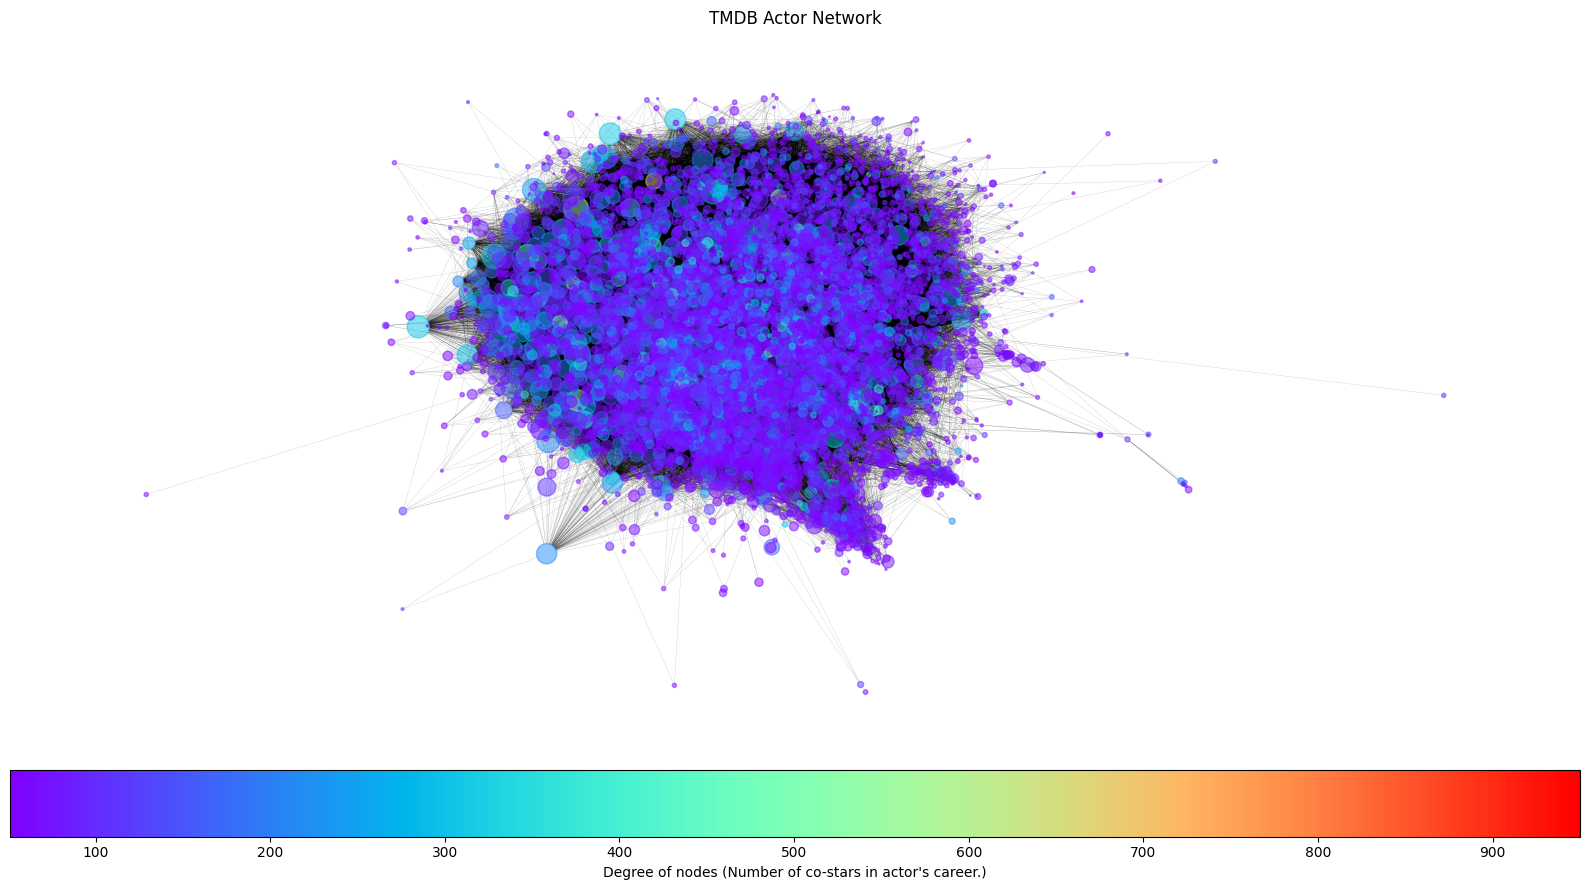

In [72]:
# Define figure size and gridspec layout
fig = plt.figure(figsize=(16, 9))

# Divide the figure into 10 equal rows
gs = fig.add_gridspec(10, 1)

# Graph plot (top 9/10 of the figure)
ax_graph = fig.add_subplot(gs[:9, 0])
nx.draw(
    GRAPH,
    pos=positions,
    ax=ax_graph,  # Use the defined axis
    node_size=DEGREE_VALUES,
    alpha=0.5,
    node_color=NODE_COLORS,
    width=0.1,
    with_labels=False
)

# Set title of plot
ax_graph.set_title("TMDB Actor Network")

# Colorbar plot (bottom 1/10 of the figure)
ax_colorbar = fig.add_subplot(gs[9, 0])  # The bottom 1 row for the colorbar

# Colorbar code
vals = [GRAPH.nodes[node][ATTRIBUTE] for node in GRAPH.nodes if ATTRIBUTE in GRAPH.nodes[node]]
cmap = colormaps[COLOR_MAP]
norm = mpl.colors.Normalize(vmin=min(vals), vmax=max(vals))

# Create the colorbar on the designated axis
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax_colorbar,
    orientation='horizontal',
    label="Degree of nodes (Number of co-stars in actor's career.)"
)

# Adjust layout to ensure colorbar and graph are not overlapping
plt.tight_layout()

ACTOR_GRAPH_PATH_PDF = os.path.join(os.path.abspath(""), "plots", "ACTORS_network_fa2.pdf")
ACTOR_GRAPH_PATH_PNG = os.path.join(os.path.abspath(""), "plots", "ACTORS_network_fa2.png")
plt.savefig(ACTOR_GRAPH_PATH_PDF, format = "pdf", bbox_inches="tight")
plt.savefig(ACTOR_GRAPH_PATH_PNG, format = "png", bbox_inches="tight")

plt.show()